In [197]:
# Make the following code support python2 and python3
from __future__ import division, print_function, unicode_literals

# Check if the version of python is 3.5 and above
import sys
assert sys.version_info >= (3, 5)

# Check to see if sklearn is version 0.20 and above
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os 

# The result obtained after each run is the same as that of this notebook
np.random.seed(42) 

# Make matplotlib diagrams work better
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Setting the route to save the image
PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True):
    '''
    Run to save automatic pictures
    
    fig_id : Picture Name
    '''
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
# Ignore the useless warnings (Scipy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [198]:
df = pd.read_excel("data1.xlsx", engine="openpyxl")

In [199]:
# read the first five data of the data set
df.head()

,TRUE VALUE,SiO2(w.t.%),TiO2(w.t.%),Al2O3(w.t.%),Cr2O3(w.t.%),Fe2O3 (t)(w.t.%),MnO(w.t.%),NiO(w.t.%),MgO(w.t.%)
0,1,40.88,0.02,0.73,0.1,6.66,0.12,0.19,36.95
1,1,41.15,0.02,0.63,0.1,6.94,0.13,0.19,37.34
2,1,44.30,0.03,1.27,0.1,6.35,0.12,0.19,35.09
3,1,40.86,0.06,1.21,0.1,6.98,0.13,0.19,36.38
4,1,42.72,0.05,1.13,0.1,6.14,0.14,0.19,35.95


In [200]:
# check whether there is null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRUE VALUE        122 non-null    int64  
 1   SiO2(w.t.%)       122 non-null    float64
 2   TiO2(w.t.%)       122 non-null    float64
 3   Al2O3(w.t.%)      122 non-null    float64
 4   Cr2O3(w.t.%)      122 non-null    float64
 5   Fe2O3 (t)(w.t.%)  122 non-null    float64
 6   MnO(w.t.%)        122 non-null    float64
 7   NiO(w.t.%)        122 non-null    float64
 8   MgO(w.t.%)        122 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 8.7 KB


In [201]:
df[["TRUE VALUE", "SiO2(w.t.%)"]].groupby(["TRUE VALUE"]).mean()

,SiO2(w.t.%)
TRUE VALUE,
-1,41.657097
1,40.088078


In [202]:
# data sets that don't contain classification label
X = df.drop("TRUE VALUE", axis=1)
# Columns that contain classification label
y = df["TRUE VALUE"]

In [203]:
# the type of the labels of the original data sets
tag = list(np.unique(y))
tag

[-1, 1]

In [204]:
y.value_counts()

 1    91
-1    31
Name: TRUE VALUE, dtype: int64

In [205]:
from sklearn.preprocessing import StandardScaler

# data need to be standardized before dimension reduction for dimensionless method,
# but SVMs are sensitive to the feature scales
scaler = StandardScaler()
X_processed = pd.DataFrame(scaler.fit_transform(X))

In [206]:
from sklearn.decomposition import PCA

# PCA assumes that the origin is centered, the data set is centralized automatically
pca = PCA(n_components=2)
# reduce the data set down to 2-dimensional space
X_reduced = pca.fit_transform(X_processed)
X_reduced.shape

(122, 2)

In [215]:
# get the range of the x axis and y axis for 2-dimensional plot
axes_range = [X_reduced[:, 0].min()-0.5, X_reduced[:, 0].max()+0.5, X_reduced[:, 1].min()-0.5, X_reduced[:, 1].max()+0.5]

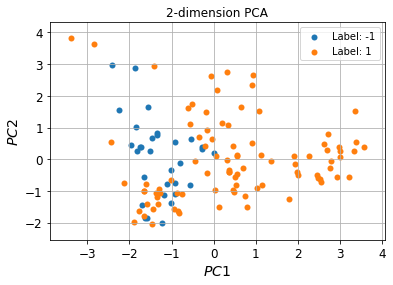

In [216]:
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    """draw a plot where the data are in 2-dimensinal space
    
    :param X: data 
    :param y: classes
    :axes: the range of axes respectively
    """
    
    plt.figure(1, figsize=(8, 6))

    legend = []
    # Draw a data point projection plot that is projected to a two-dimensional plane using normal PCA
    for i, label in enumerate(tag):
        plt.scatter(X[:, 0][y==label], X[:, 1][y==label], linewidth=0.01)
        legend.append("Label: {}".format(label))
    plt.legend(legend)
    plt.axis(axes)
    plt.xlabel("$PC1$")
    plt.ylabel("$PC2$")
    plt.grid()

plt.title("2-dimension PCA")
plot_dataset(X_reduced, y, axes_range)

# Linear SVM Classification

In [217]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    """plot decision boundary for Linear SVM  
    
    :param svm_clf: svm model
    :param xmin: the lower limit of the x column 
    :param xmax: the upper limit of the x column
    """
    
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=10, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [218]:
from sklearn.svm import SVC

# SVM Classifier model, a smaller C value leads to a wider street but more margin violations
svm_clf = SVC(kernel="linear", C=1000)
svm_clf.fit(X_reduced, y)

SVC(C=1000, kernel='linear')

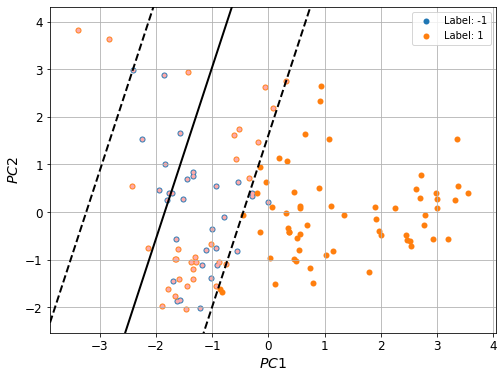

In [219]:
plot_dataset(X_reduced, y, axes_range)
plot_svc_decision_boundary(svm_clf, -4, 4)

# Non-Linear SVM Classification

In [220]:
def plot_predictions(clf, axes):
    """plot the non-linear classification plot
    
    :param clf: the classifier
    :param axes: list, the range of the axes respectively
    """
    
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    # calculate the distance of the samples X to the separating hyperplane
    y_prediction = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmam=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_prediction, cmap=plt.cm.brg, alpha=0.1)

In [221]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

poly_kernel_svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=5)
poly_kernel_svm_clf.fit(X_reduced, y)

SVC(C=5, coef0=1, kernel='poly')

<ipython-input-220-8f9de7b0a653>:16: UserWarning: The following kwargs were not used by contour: 'cmam'
  plt.contourf(x0, x1, y_pred, cmam=plt.cm.brg, alpha=0.2)


Saving figure kernelized_polynomial_svc_plot


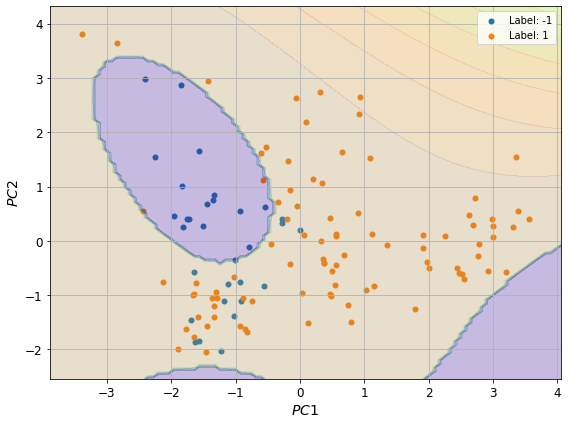

In [222]:
plot_dataset(X_reduced, y, axes_range)
plot_predictions(poly_kernel_svm_clf, axes_range)

save_fig("kernelized_polynomial_svc_plot")

In [223]:
rbf_kernel_svm_clf = SVC(kernel="rbf", gamma=0.1, C=10)
rbf_kernel_svm_clf.fit(X_reduced, y)

SVC(C=10, gamma=0.1)

In [224]:
sigmoid_kernel_svm_clf = SVC(kernel="sigmoid", gamma=0.1, coef0=1, C=10)
sigmoid_kernel_svm_clf.fit(X_reduced, y)

SVC(C=10, coef0=1, gamma=0.1, kernel='sigmoid')

<ipython-input-220-8f9de7b0a653>:16: UserWarning: The following kwargs were not used by contour: 'cmam'
  plt.contourf(x0, x1, y_pred, cmam=plt.cm.brg, alpha=0.2)
<ipython-input-220-8f9de7b0a653>:16: UserWarning: The following kwargs were not used by contour: 'cmam'
  plt.contourf(x0, x1, y_pred, cmam=plt.cm.brg, alpha=0.2)


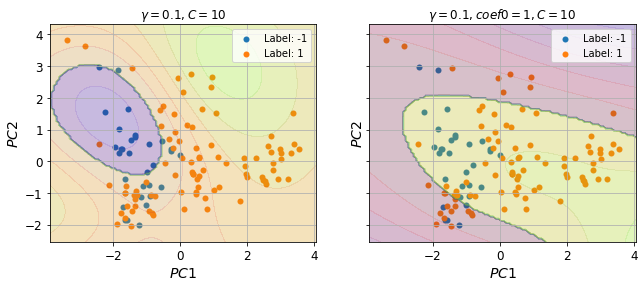

In [225]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_dataset(X_reduced, y, axes_range)
plot_predictions(rbf_kernel_svm_clf, axes_range)
plt.title(r"$\gamma=0.1, C=10$")

plt.sca(axes[1])
plot_dataset(X_reduced, y, axes_range)
plot_predictions(sigmoid_kernel_svm_clf, axes_range)
plt.title(r"$\gamma=0.1, coef0=1, C=10$")

plt.show()

[LibSVM]0 0.1 0.31252408027648926
[LibSVM]1 0.01 0.5576381683349609
[LibSVM]2 0.001 2.8446741104125977
[LibSVM]3 0.0001 3.0710320472717285
[LibSVM]4 1e-05 3.4556779861450195
[LibSVM]5 1.0000000000000002e-06 3.5690419673919678
[LibSVM]6 1.0000000000000002e-07 2.694470167160034
[LibSVM]7 1.0000000000000002e-08 3.448937177658081
[LibSVM]8 1.0000000000000003e-09 3.4144837856292725
[LibSVM]9 1.0000000000000003e-10 3.493892192840576


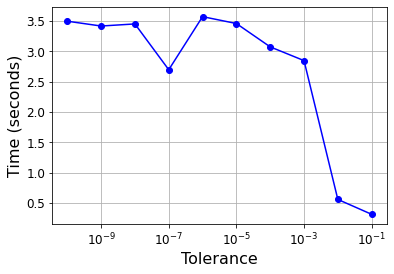

Saving figure tolerance_time_plot


<Figure size 432x288 with 0 Axes>

In [226]:
import time

# tolerance for stopping criterion
tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf1 = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf1.fit(X_reduced, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
# make a plot with log scaling on the x axis
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()
save_fig("tolerance_time_plot")

## Grid Search

In [227]:
# data sets that don't contain classification label
X = df.drop("TRUE VALUE", axis=1)

In [228]:
from sklearn.model_selection import train_test_split

# split data set into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
from sklearn.preprocessing import StandardScaler

# svm algorithm is sensitive to scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [230]:
svm_clf2 = SVC(kernel="rbf", gamma="scale")
svm_clf2.fit(X_train_scaled, y_train)

SVC()

In [241]:
from sklearn.metrics import accuracy_score

y_pred = svm_clf2.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9175257731958762

In [242]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# find the best combination of hyperparameters of SVM model
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf2, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=10.093204020787821, gamma=0.0032927591344236156 ...............
[CV]  C=10.093204020787821, gamma=0.0032927591344236156, total=   0.0s
[CV] C=10.093204020787821, gamma=0.0032927591344236156 ...............
[CV]  C=10.093204020787821, gamma=0.0032927591344236156, total=   0.0s
[CV] C=10.093204020787821, gamma=0.0032927591344236156 ...............
[CV]  C=10.093204020787821, gamma=0.0032927591344236156, total=   0.0s
[CV] C=7.62522284353982, gamma=0.004201672054372529 ..................
[CV] ... C=7.62522284353982, gamma=0.004201672054372529, total=   0.0s
[CV] C=7.62522284353982, gamma=0.004201672054372529 ..................
[CV] ... C=7.62522284353982, gamma=0.004201672054372529, total=   0.0s
[CV] C=7.62522284353982, gamma=0.004201672054372529 ..................
[CV] ... C=7.62522284353982, gamma=0.004201672054372529, total=   0.0s
[CV] C=6.200680211778108, gamma=0.01239996783684609 ..................
[CV] ... C=6.200

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x125a15df0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1259daa00>},
                   verbose=2)

In [243]:
# the best model among ten of the trained models 
rnd_search_cv.best_estimator_

SVC(C=6.200680211778108, gamma=0.01239996783684609)

In [244]:
# the best score of the best model
rnd_search_cv.best_score_

0.8970959595959597

## Metrics for Binary Classifiers 

In [246]:
from sklearn.model_selection import cross_val_predict

svm_clf3 = SVC(kernel="rbf", gamma="scale")

# get a "clean" prediction for each instance in the training set
y_train_pred = cross_val_predict(svm_clf3, X_train_scaled, y_train, cv=3)

In [256]:
y_train_pred

array([ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1])

### Precision & Recall

In [247]:
from sklearn.metrics import confusion_matrix

# confusion matrix, each row represents an actual class, while each column represented a predicted class
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[16, 10],
       [ 1, 70]])

([<matplotlib.axis.YTick at 0x12549fa30>,
 [Text(0, 0.5, '1'), Text(0, 1.5, '-1')])

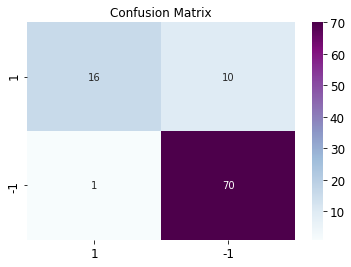

In [248]:
import seaborn as sn

classes = list(y_train.unique())
# location for labels in x-axis
tick_marks = np.arange(len(classes)) + 0.5
plt.title("Confusion Matrix")
sn.heatmap(cm, annot=True, cmap="BuPu")
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

In [249]:
from sklearn.metrics import precision_score, recall_score

# The precision is intuitively the ability of the classifier not to label a sample, which is negative, as positive.
precision_score(y_train, y_train_pred)

0.875

In [250]:
# The recall is intuitively the ability of the classifier to find all the positive samples.
recall_score(y_train, y_train_pred)

0.9859154929577465

In [251]:
from sklearn.metrics import f1_score

# F1 = 2 * (precision * recall) / (precision + recall)
f1_score(y_train, y_train_pred)

0.9271523178807948

In [253]:
from sklearn.metrics import classification_report

# build a text report showing the main classification metrics.
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

          -1       0.94      0.62      0.74        26
           1       0.88      0.99      0.93        71

    accuracy                           0.89        97
   macro avg       0.91      0.80      0.84        97
weighted avg       0.89      0.89      0.88        97



In [257]:
# each element represents whether a predicted sample for x_train (seen as testing set in cross_val_predict) 
# by the classifier lies to the right or left side of the Hyperplane and also how far from the HyperPlane.
y_scores = cross_val_predict(svm_clf3, X_train_scaled, y_train, cv=3,
                             method="decision_function")

In [258]:
# how confidently each value predicted for x_test by the classifier 
# is Positive ( large-magnitude Positive value ) or Negative ( large-magnitude Negative value)
y_scores

array([ 1.06112046, -0.97499074,  0.82217922,  1.10641472, -0.97465214,
        0.42344603, -0.58887774,  1.00667347,  0.52780509,  1.01523156,
        0.88858492,  0.93406021,  1.31320451,  1.22260519,  1.04387257,
        1.05302903,  1.03350029,  1.10060102,  0.70788732,  1.01615902,
        0.99869961,  1.02671288,  1.03806629,  0.51502737,  1.44666657,
        0.92669397,  1.00505629,  1.03149163, -0.76342876,  1.07365682,
        1.077697  ,  0.76755383,  1.36214154,  1.0543972 ,  0.60207401,
        1.10520634,  0.64222504,  1.21590861, -0.94779486,  0.55692603,
        1.21873233,  1.19220302, -1.18792095,  1.02730242,  0.86625177,
       -1.2234815 ,  1.249985  ,  0.94165031,  1.40705825,  1.28260524,
       -1.22127578,  0.76380686,  1.1292248 , -0.09632317,  0.61583278,
        0.50662927,  0.8790823 ,  1.44053471,  0.99893103,  0.89055941,
        0.78554362,  1.39932342,  1.05370125,  0.41911538,  0.61203274,
        1.47744798,  0.77956466,  1.158259  ,  1.07509107,  0.93

In [259]:
from sklearn.metrics import precision_recall_curve

# compute precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [260]:
precision_recall_curve?

In [262]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """plot precision_recall_curve
    
    :param precisions: array
    :param recalls: array
    :param thresholds: array, increasing thresholds on the decision function used to compute precision and recall.
    """
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                                       

Saving figure precision_recall_vs_threshold_plot


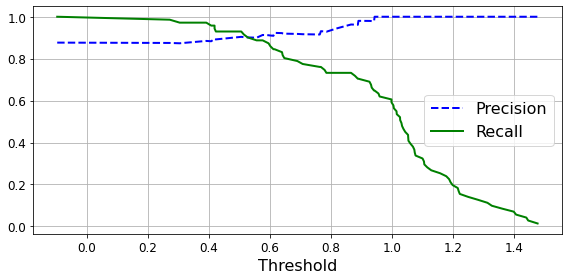

In [263]:
plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

Saving figure precision_vs_recall_plot


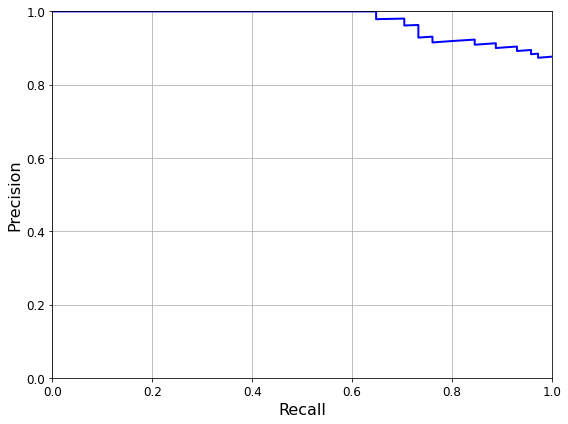

In [264]:
def plot_precision_vs_recall(precisions, recalls):
    """plot precision_vs_recall
    
    :param precisions: array
    :param recalls: array
    
    """
    
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [265]:
# np.argmax() will find the first index of the maximum value, which in this case means the first True value
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

0.5066292722401778

In [266]:
# if we want a 90% precision classifier, set the element as True if its decision_function value beyond the 90% precision threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True,  True, False,  True, False,
        True,  True, False, False, False,  True, False])

In [267]:
y_train_true = []
# alternate 1 with True, -1 with False
for i in range(len(y_train)):
    if list(y_train)[i] == 1:
        y_train_true.append(True)
    else:
        y_train_true.append(False)

In [268]:
# the 90% precision classifier
precision_score(y_train_true, y_train_pred_90)

0.9041095890410958

In [269]:
# the corresponding recall value in terms of the 90% precision classifier
recall_score(y_train_true, y_train_pred_90)

0.9295774647887324

### ROC Curves

In [270]:
from sklearn.metrics import roc_curve

# compute Receiver operating characteristic (ROC)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

Saving figure roc_curve_plot


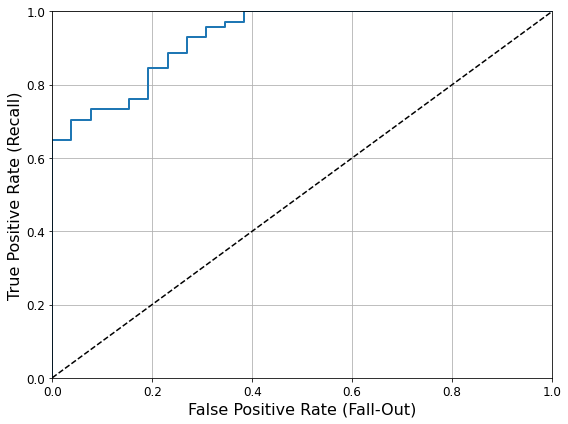

In [273]:
def plot_roc_curve(fpr, tpr):
    """plots the true positive rate (another name for recall) against the false positive rate
    
    :param fpr: false positive rate
    :param tpr: true positive rate
    """
    
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)   

plt.figure(figsize=(8, 6))  
# The dashed diagonal line represents the ROC curve of a purely random classifier;
# a good classifier stays as far away from that line as possible (toward the top-left corner)
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")                        
plt.show()

In [274]:
from sklearn.metrics import roc_auc_score

# the area under the curve, perfect classifier will have a ROC AUC equal to 1,
# whereas a purely random classifier will have a ROC AUC equal to 0.5
roc_auc_score(y_train, y_scores)

0.9295774647887325

# Multiclass Classification

In [275]:
df2 = pd.read_excel("data2.xlsx", engine="openpyxl")

In [276]:
df2.head()

,TRUE VALUE,SiO2 (wt. %),TiO2 (wt. %),Al2O3 (wt. %),Cr2O3 (wt. %),FeO (wt. %),MnO (wt. %),MgO (wt. %),CaO (wt. %),Na2O (wt. %),IV (Al),H2O (wt. %)
0,1,47.604,2.858,5.749,0.062,7.024,0.087,12.625,22.916,0.328,0.207900,0.061750
1,1,51.788,1.166,2.557,0.475,6.801,0.145,14.762,21.743,0.327,0.080071,0.014881
2,1,46.561,3.109,6.139,0.145,6.914,0.037,12.478,23.112,0.620,0.238984,0.023204
3,1,46.344,3.170,7.776,0.014,6.842,0.068,11.688,23.067,0.574,0.258931,0.049703
4,1,50.180,1.965,3.294,0.106,5.729,0.063,13.603,23.626,0.540,0.121500,0.019333


In [277]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TRUE VALUE     2272 non-null   int64  
 1   SiO2 (wt. %)   2272 non-null   float64
 2   TiO2 (wt. %)   2272 non-null   float64
 3   Al2O3 (wt. %)  2272 non-null   float64
 4   Cr2O3 (wt. %)  2272 non-null   float64
 5   FeO (wt. %)    2272 non-null   float64
 6   MnO (wt. %)    2272 non-null   float64
 7   MgO (wt. %)    2272 non-null   float64
 8   CaO (wt. %)    2272 non-null   float64
 9   Na2O  (wt. %)  2272 non-null   float64
 10  IV (Al)        2272 non-null   float64
 11  H2O (wt. %)    2272 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 213.1 KB


In [278]:
X = df2.drop("TRUE VALUE", axis=1)
y = df2["TRUE VALUE"]

In [279]:
y.unique()

array([ 1, -1,  0])

In [280]:
y.value_counts()

 1    1488
-1     467
 0     317
Name: TRUE VALUE, dtype: int64

In [281]:
from sklearn.model_selection import train_test_split

# split data set into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
from sklearn.multiclass import OneVsOneClassifier

# one-versus-one strategy, train a series of binary classifier for every pair of classes
# e.g -1 vs 1, -1 vs 0, 0 vs 1
ovo_clf = OneVsOneClassifier(SVC(gamma="auto", random_state=42))
ovo_clf.fit(X_train, y_train)
y_pred_ovo = ovo_clf.predict(X_test)

In [283]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_ovo)

0.8043956043956044

In [284]:
# if there are N classes, it will train N X (N - 1) / 2 classifiers
len(ovo_clf.estimators_)

3

In [285]:
from sklearn.multiclass import OneVsRestClassifier

# this strategy consists in fitting one classifier per class.
# for each classifier, the class is fitted against all the other classes
# e.g -1 vs non -1, 1 vs non 1, 0 vs non 0
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train, y_train)
y_pred_ovr = ovr_clf.predict(X_test)

In [286]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_ovr)

0.8153846153846154

In [287]:
# if there are N classes, it will train N classifiers
len(ovr_clf.estimators_)

3

In [288]:
from sklearn.model_selection import cross_val_score

# use cross-validation skill
ovo_svm_scores = cross_val_score(ovo_clf, X_train, y_train, cv=10)
ovo_svm_scores.mean()

0.799653937222998

In [290]:
# use cross-validation skill
ovr_svm_scores = cross_val_score(ovr_clf, X_train, y_train, cv=10)
ovr_svm_scores.mean()

0.8062594863699836

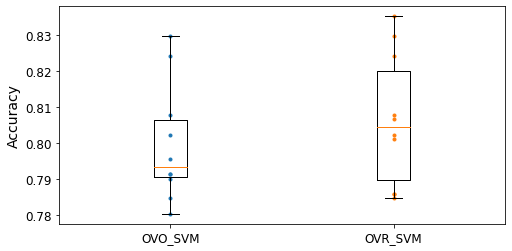

In [291]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, ovo_svm_scores, ".")
plt.plot([2]*10, ovr_svm_scores, ".")
# if the lower quartile is Q1 and the upper quartile is Q3,
# then the interquartile range IQR = Q3 - Q1 (this is the box's height),
# and any score lower than Q1 - 1.5 x IQR is a flier("outliers"),
# and so is any score greater than Q3 + 1.5 X IQR 
plt.boxplot([ovo_svm_scores, ovr_svm_scores], labels=("OVO_SVM","OVR_SVM"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# Multilabel Classification

In [292]:
from sklearn.neighbors import KNeighborsClassifier

# classes like 0, 1
y_train_non_neg = (y_train >= 0)
# class like -1
y_train_neg = (y_train < 0)
y_multilabel = np.c_[y_train_non_neg, y_train_neg]

# KNN supports multilabel classification, but not all classifiers (i.e, SVC) do
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [293]:
knn_clf.predict(X_test)

array([[ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ Tr

In [294]:
from sklearn.metrics import f1_score

# F1 score for each individual label, then simply compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.7584005401074425

In [295]:
# give weight to the classifier's score on the label
# depending on the number of instances with that target label
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.8471516637852299

# Error Analysis

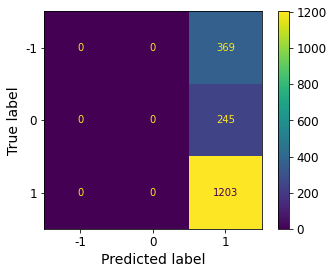

In [296]:
from sklearn.metrics import plot_confusion_matrix

svm_clf4 = SVC(gamma="scale")
svm_clf4.fit(X_train, y_train)
plot_confusion_matrix(svm_clf4, X_train, y_train)

In [297]:
from sklearn.model_selection import cross_val_predict

svm_clf5 = SVC(gamma="scale")
y_train_pred = cross_val_predict(svm_clf5, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[   0,    0,  369],
       [   0,    0,  245],
       [   0,    0, 1203]])

In [298]:
def confusion_matrix_plot(conf_mx, classes):
    """plot confusion matrix
    
    :param conf_mx: confusion matrix value
    :param classes: the name of the classes
    """
    
    # location for labels in x-axis
    tick_marks = np.arange(len(classes))
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.title("Confusion Matrix")
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

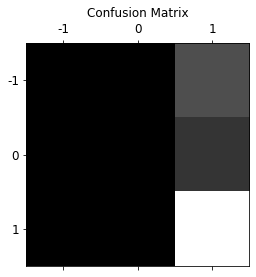

In [299]:
confusion_matrix_plot(conf_mx, [-1, 0, 1])

In [300]:
# divide each value in the confusion matrix by the number of true corresponding classes,
# compare error rate instead of absolute number of errors, which would make abundant classes look unfairly bad
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

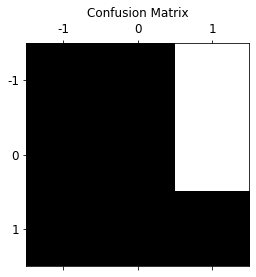

In [302]:
np.fill_diagonal(norm_conf_mx, 0)
# the column for class 1 is quite bright, which tells many elements misclassified as 1
confusion_matrix_plot(norm_conf_mx, [-1, 0, 1])

# SVM Regression

In [303]:
df3 = pd.read_excel("data3.xlsx", engine="openpyxl")

In [304]:
df3.head()

,Si,Ti,Al,Cr,Fe,Mn,Mg,Ca,Na,Fe3+/Fetot
0,1.880934,0.015039,0.287436,0.021552,0.077207,0.002771,0.801373,0.790934,0.141648,0.245730
1,1.892376,0.015528,0.284656,0.020327,0.078130,0.002454,0.773549,0.810870,0.119354,0.260358
2,1.904724,0.013995,0.268677,0.025377,0.068329,0.001545,0.788436,0.793338,0.137905,0.236632
3,1.897332,0.013840,0.260175,0.021959,0.095928,0.002750,0.822183,0.777593,0.109102,0.181867
4,1.889801,0.015017,0.273757,0.019512,0.098037,0.002459,0.821304,0.769558,0.114701,0.147499


In [305]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Si          387 non-null    float64
 1   Ti          387 non-null    float64
 2   Al          387 non-null    float64
 3   Cr          387 non-null    float64
 4   Fe          387 non-null    float64
 5   Mn          387 non-null    float64
 6   Mg          387 non-null    float64
 7   Ca          387 non-null    float64
 8   Na          387 non-null    float64
 9   Fe3+/Fetot  387 non-null    float64
dtypes: float64(10)
memory usage: 30.4 KB


In [306]:
X = df3.drop("Fe3+/Fetot", axis=1)
y = df3["Fe3+/Fetot"]

In [307]:
from sklearn.model_selection import train_test_split

# split data set into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
def find_support_vectors(svm_reg, X, y):
    """find support vectors of SVR
    
    :param svm_reg: a SVM Regressor
    :param X: data
    :param y: labels
    """
    y_pred = svm_reg.predict(X)
    # evalute whether the instance is off the street line
    off_margin = np.array(np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

In [140]:
def plot_svm_regression(svm_reg, X, y, axes):

    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_].reshape(-1, 1), np.array(y)[svm_reg.support_].reshape(-1, 1), s=180, facecolors='#FFAAAA')
    
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

In [141]:
from sklearn.decomposition import PCA

# PCA assumes that the origin is centered, the data set is centralized automatically
pca = PCA(n_components=1)
# reduce the data set down to 2-dimensional space
X_reduced = pca.fit_transform(X)
X_reduced.shape

(387, 1)

In [149]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=0.1, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.2, random_state=42)
svm_reg1.fit(X_reduced, y)
svm_reg2.fit(X_reduced, y)

LinearSVR(epsilon=0.2, random_state=42)

In [151]:
svm_reg1.support_ = find_support_vectors(svm_reg1, X_reduced, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X_reduced, y)

In [145]:
X_reduced[svm_reg1.support_].reshape(-1, 1).shape

(101, 1)

In [146]:
axes_range = [X_reduced.min(), X_reduced.max(), y.min(), y.max()]
axes_range

[-0.4320548881296569, 1.5674063069036328, 0.0, 1.0]

Saving figure svm_regression_plot


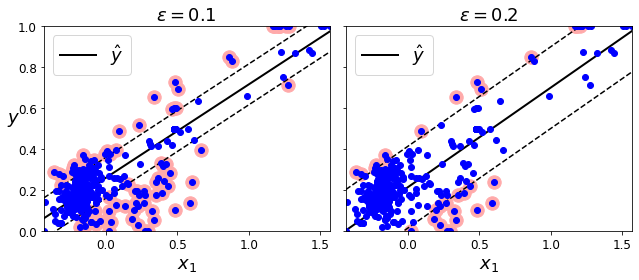

In [153]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X_reduced, y, axes_range)
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

plt.sca(axes[1])
plot_svm_regression(svm_reg2, X_reduced, y, axes_range)
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [154]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X_reduced, y)
svm_poly_reg2.fit(X_reduced, y)

SVR(C=0.01, degree=2, kernel='poly')

Saving figure svm_with_polynomial_kernel_plot


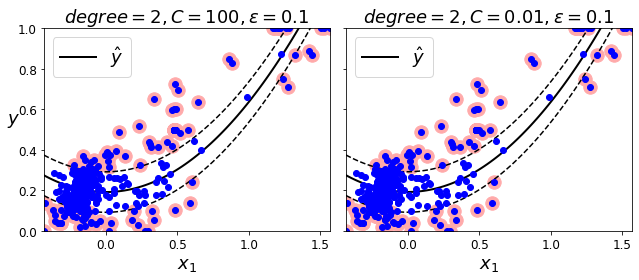

In [155]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X_reduced, y, axes_range)
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X_reduced, y, axes_range)
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()